# This code is actually an example of how to visualize from a given layer or subset of layers what patterns of images are they getting "excited" by.

In [0]:
!pip install -q tensorflow==2.0.0-alpha0

     |████████████████████████████████| 79.9MB 1.6MB/s 
     |████████████████████████████████| 419kB 47.9MB/s 
     |████████████████████████████████| 3.0MB 47.9MB/s 


In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import clear_output 
print(tf.__version__)

2.0.0-alpha0


# Download img

In [0]:
def download(url):
  name = url.split("/")[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = image.load_img(image_path)
  return image.img_to_array(img)

def preprocess(img):
  return (img / 127.5) - 1

def deprocess(img):
  img = img.copy()
  img /= 2.
  img += 0.5
  img += 255.
  return np.clip(img,0,255).astype('uint8')

def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)

# Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


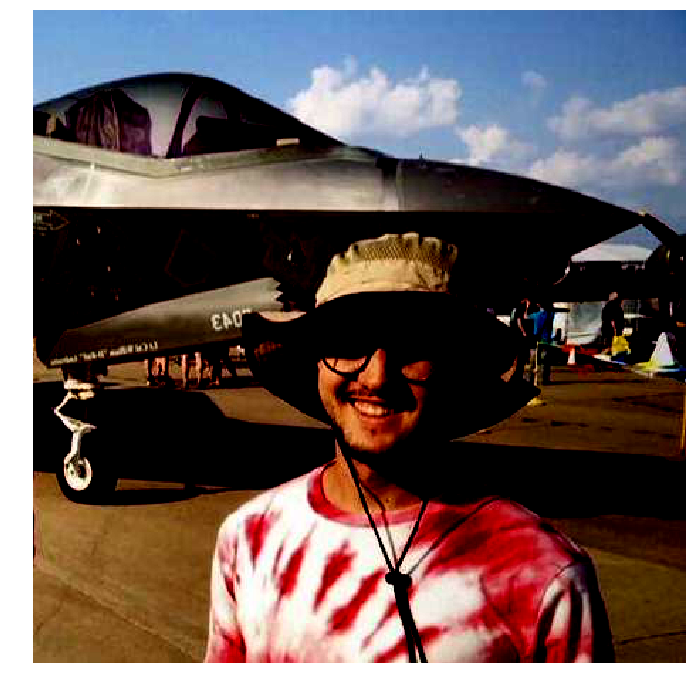

In [76]:
url = 'https://avatars1.githubusercontent.com/u/26509469?s=460&v=4'
img = preprocess(download(url))
show(img)

# Inception_V3

In [31]:
inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False)
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_v1_94[0][0]  
_______________________________________________________________________________________

In [0]:
names = ['mixed7','mixed6','activation_147','conv2d_160','mixed8']
layers = [inception_v3.get_layer(name).output for name in names]
feature_extraction_model = tf.keras.Model(inputs=inception_v3.input,outputs=layers)

In [0]:
def forward(img):
  img_batch = tf.expand_dims(img, axis=0)
  return feature_extraction_model(img_batch)

In [0]:
def calc_loss(layer_activations):
  total_loss = 0
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    loss /= np.prod(act.shape)
    total_loss += loss
  return total_loss


# Here we take our image as a variable and keep forwarding it through the pre-trained model without changing the model but the image by adding the gradient of the loss with respect for each pixel on the image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


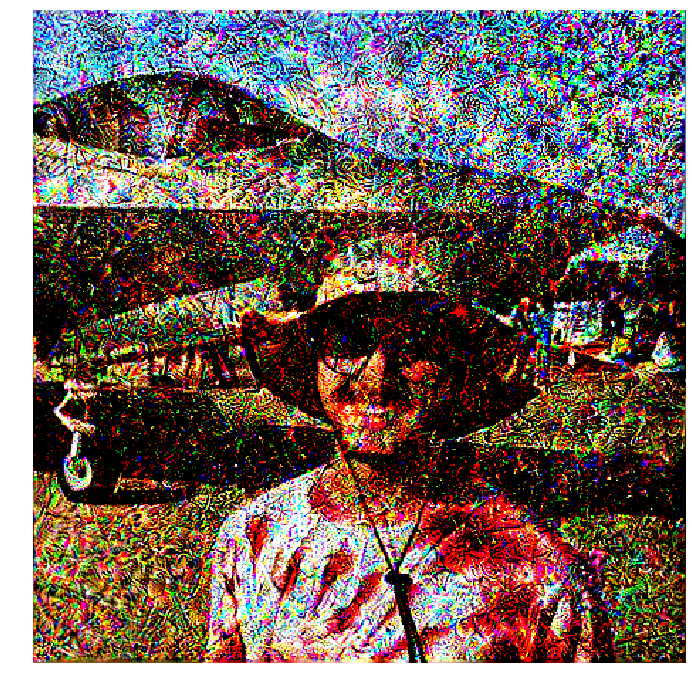

In [77]:
img = tf.Variable(img)
steps = 400 
for step in range(steps):
  with tf.GradientTape() as tape:
    activations = forward(img)
    loss = calc_loss(activations)
  gradients = tape.gradient(loss,img)
  gradients /= gradients.numpy().std() + 1e-8
  img.assign_add(gradients)
  if step % 50 == 0:
    clear_output()
    print('Step %d, loss %f' % (step,loss))
    show(img.numpy())
    plt.show()

clear_output()
show(img.numpy())
